## Customer Segmentation by RFM model and K-Means

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It was my first day as a data analyst in a cosmetics online store. My supervisor sent me a link to a shared folder that contained 5 medium-sized csv files. “We may launch a marketing campaign soon, take a look at these files and see if you can group our customers,” he said to me a few minutes before he left for a business trip.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;After taking a deep breath, I glanced through the files. Each file contained customer behavior data for a month. The data were collected from Oct 2019 to Feb 2020.  Next, I combined these files in python and added a column “month”.

In [1]:
# import modules
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

In [2]:
# read data
files_csv=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files_csv.append(os.path.join(dirname, filename))
frame=[]
for i in range(len(files_csv)):
    df_i=pd.read_csv(files_csv[i])
    df_i['month']=files_csv[i][-7:-4]
    frame.append(df_i)
df=pd.concat(frame,ignore_index=True,sort=False)
print("The dataframe has {} rows and {} columns.\n".format(df.shape[0],df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(df.head(3))

The dataframe has 20692840 rows and 10 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,Dec
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,Dec
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,Dec


### Part I: Initial Dataset Preparation and Data Exploration

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Since the goal was to segment customers to help with marketing campaigns, I decided to start with the simple but very effective RFM model. Briefly, the RFM analysis is based on 3 factors – how recently (Recency), how often (Frequency), and how much (Monetary Value) did the customer buy. Next, I selected the rows and columns needed, and cleaned the data.

In [3]:
# data preparation

# step 1: select customers who purchased
df_sales=df.loc[df.event_type=='purchase',:]

# step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
df_sales=df_sales.drop(columns=['category_code','brand','product_id','category_id','user_session'])

# step 3: drop duplicates
df_sales=df_sales.drop_duplicates()

# step 4: convert "event_time" to DateTime format
df_sales['event_time']=pd.to_datetime(df_sales['event_time'],infer_datetime_format=True)

nullcolumns=df_sales.isnull().sum()
nullnumbers=len(nullcolumns[nullcolumns!=0])
print("After data selection and cleansing, the dataframe has {} rows, {} columns, and {} null value.\n".format(df_sales.shape[0],df_sales.shape[1],nullnumbers))
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
display(df_sales.head(3))

After data selection and cleansing, the dataframe has 908776 rows, 5 columns, and 0 null value.

Shown below are the first 3 rows of the cleaned dataframe:



,event_time,event_type,price,user_id,month
557,2019-12-01 00:17:50,purchase,0.38,473613801,Dec
560,2019-12-01 00:17:50,purchase,0.37,473613801,Dec
565,2019-12-01 00:17:50,purchase,0.41,473613801,Dec


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Initial exploration of the cleaned data showed that (1) the number of customers spiked in Nov 2019 and the end of Jan 2020. There was a big drop in customer numbers on New Year’s Eve; (2) sales went up from ~0.95 million dollars in Oct 2019 to ~1.3 million dollars in Nov 2019, fell to ~0.85 million dollars in Dec 2019, and then remained ~1 million dollars/month in the following 2 months; (3) the average spend per customer didn’t change much over the 5 months.

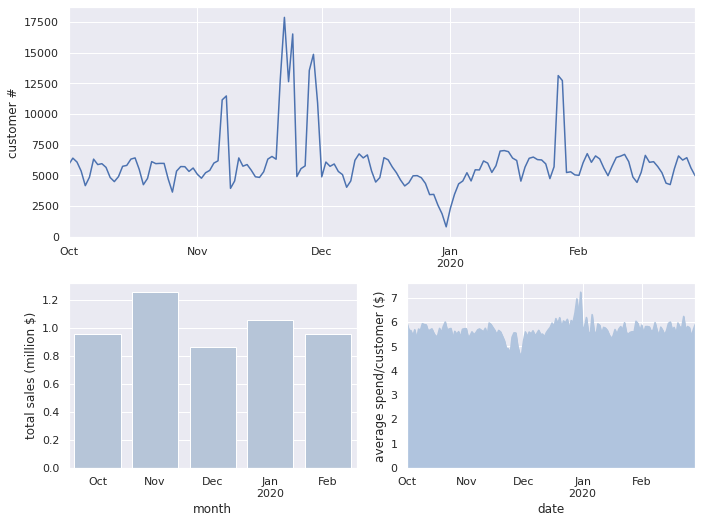

In [4]:
# initial data exploration

plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.08, 0.4, 0.87, 0.4])
df_sales_n_user=df_sales.resample("D",on='event_time')['user_id'].size()
df_sales_n_user.plot(kind='line')
plt.xlabel('')
plt.ylabel('customer #')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=df_sales.resample('M',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov','Dec',"Jan\n2020", "Feb"]
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="lightsteelblue")
plt.xlabel('month')
plt.ylabel('total sales (million $)')

# plot average spend/customer
plt.axes([0.55,0,0.4,0.32])
df_sales_p_day=df_sales.resample('D',on='event_time')['price'].sum()
df_sales_spent=df_sales_p_day/df_sales_n_user
df_sales_spent.plot(kind='area',color="lightsteelblue")
plt.xlabel('date')
plt.ylabel('average spend/customer ($)');

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, I grouped the data by user_id, and calculated each customer’s Recency (how many months until Feb 29, 2020 had it been since the customer’s last purchase), Frequency (how often had the customer made a purchase from Oct 2019 to Feb 2020), and Monetary Value(how much did the customer spend from Oct 2019 to Feb 2020). I got this:

In [5]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
d=con={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
df_sales.loc[:,'Recency']=df_sales['month'].map(d)
df_R=df_sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 2: calculate "Frequency"
df_F=df_sales.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})

# step 3: calculate "Monetary"
df_M=df_sales.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})

# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

# step 5: remove outliers before K-Means clustering
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head(3)

,user_id,Recency,Frequency,Monetary
0,9794320,3,2,7.72
1,10079204,3,2,25.81
2,10280338,0,19,63.29


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Initial examination of the RFM data revealed: (1) customers were somewhat evenly distributed along the recency curve; (2) most customers made purchases fewer than 10 times; (3) most customers spent less than 100 dollars.

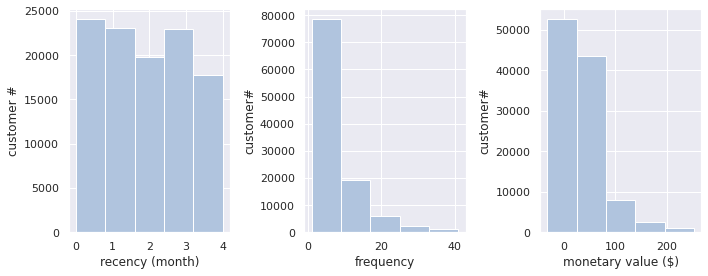

In [6]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='lightsteelblue')
ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlabel('recency (month)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='lightsteelblue')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='lightsteelblue')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

### Part II: Customer Segmentation by RFM-Based K-Means Clustering

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Traditionally, in RFM models, each customer is assigned a score for each RFM factor. These scores are then combined and used for segmentation. Inspired by Chen (2012), I decided to do RFM analysis by K-Means clustering. The first thing I did was to find the optimal number of clusters by the elbow method.

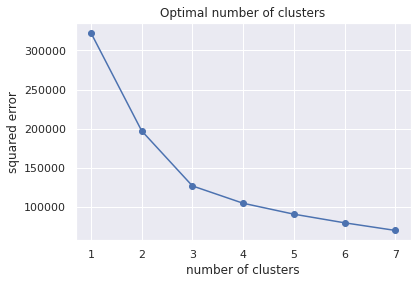

In [7]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 1: standardize data
df_RFM3=df_RFM2.drop(columns=['user_id'])
X = StandardScaler().fit_transform(df_RFM3)

# step 2: find the optimal number of clusters
SSE=[]
for i in range(1,8,1):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,8,1),SSE,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('squared error') 
plt.title('Optimal number of clusters');

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Based on the graph above, I decided to group our customers into 4 clusters. The 3D scatter plot showed that the customers were well separated.

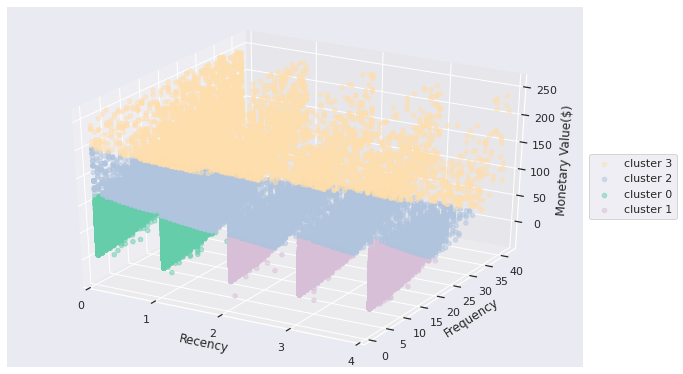

In [8]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 4 clusters
random.seed(8)
km=KMeans(n_clusters=4,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 4 clusters

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[3,2,0,1]
for i in [0,1,2,3]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in [0,1,2,3]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,4)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I must admit that I’ve never liked 3D graphs. I don’t want to call my customer segments neither “cluster 1” nor “cluster 2”. So, I replaced the old cluster names with more meaning segment names and re-plotted the data.

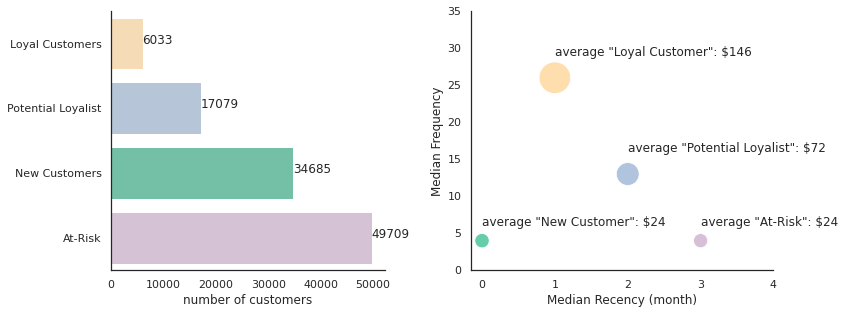

In [9]:
# replace k-means cluster names with more meaningful names
d1={0:"New Customers", 2:"Potential Loyalist", 1: "At-Risk", 3:"Loyal Customers"}
df_RFM2.loc[:,"segments"]=df_RFM2.loc[:,"clusters"].map(d1)

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
df_RFM3.loc[:,'Sales/Customer']=round(df_RFM3.loc[:,'MonetarySum']/df_RFM3.loc[:,'size'])
df_RFM3=df_RFM3.astype({'Sales/Customer':int}).reset_index()

# visualize
plt.figure(figsize=(10,4))
seg_names=['Loyal Customers','Potential Loyalist','New Customers','At-Risk']

# plot the number of customers in each segment
sns.set_style("white")
plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM2.groupby('segments').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
sns.barplot(x='number of customers',y='segments',data=seg,order=seg_names,palette=mycolors)
for i in [0,1,2,3]:
    number=int(seg.loc[seg.segments==seg_names[i],'number of customers'])
    x_pos=round(number,-2)
    plt.text(x_pos,i,number)
plt.ylabel("")
sns.despine()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM3)
plt.ylim(0,35)
plt.xticks(list(range(5)))
plt.text(1,29,'average "Loyal Customer": $146')
plt.text(2,16,'average "Potential Loyalist": $72')
plt.text(0,6,'average "New Customer": $24')
plt.text(3,6,'average "At-Risk": $24')
plt.xlabel('Median Recency (month)')
plt.ylabel('Median Frequency')
sns.despine()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Taken together, our customers were grouped into 4 segments:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1)	Loyal Customers: These customers purchased very often and spent the highest amount of money. They shopped from Oct 2019 to Feb 2020 with a median recency of 1 month. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2)	Potential Loyalist: This group shopped quite often (though not as frequent as the loyal customers) and spent reasonable amount of money (though not as high as the loyal customers). 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(3)	New Customers: I was so surprised that we had such a large group of new customers. They started shopping very recently and as a result, they didn’t make purchases often nor spent much money.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(4)	At-Risk: This is the largest-sized group!!! These customers have high recency, low frequency, and low monetary.

### Part III: Examine the Relationship between Probability of Purchasing and RFM

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As a very curious data analyst, I always like to dig a little deeper. I wanted to find out how a customer’s recency, frequency, and monetary value would affect his or her repurchase probability. To address my own question, I did the following things:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1) I calculated the Recency, Frequency, and Monetary Value of each customer using data from Oct 2019 to Jan 2020; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2)
I assigned the customers who made >=1 purchase in Feb 2020 to the “buy” (1) group, and those who didn’t buy in Feb 2020 to the “no-buy” (0) group; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(3) I grouped the data by recency, frequency, and monetary, respectively, and calculated the percentage of the “buy” group in each recency/frequency/monetary bin; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(4) I plotted the percentage (purchase probability in Feb 2020) against recency/frequency/monetary.

In [10]:
# explore the relationship between customers' purchase probability in Feb 2020 and their Recency,Frequency,
# and Monetary in previous months

# step 1: calculate recency, Frequency, and Monetary in Oct 2019-Jan 2020
df_sales1=df_sales.loc[df_sales.month!='Feb',:].copy()
d={"Oct":3,"Nov":2,"Dec":1,"Jan":0}
df_sales1.loc[:,'Recency']=df_sales1.loc[:,'month'].map(d)
df_sales1_R=df_sales1.groupby('user_id')['Recency'].min().reset_index()
df_sales1_F=df_sales1.groupby('user_id')['event_type'].count().reset_index().rename(columns={'event_type':'Frequency'})
df_sales1_RF=pd.merge(df_sales1_R,df_sales1_F,on='user_id')
df_sales1_M=df_sales1.groupby('user_id')['price'].sum().reset_index().rename(columns={'price':"Monetary"})
df_sales2=pd.merge(df_sales1_RF,df_sales1_M,on='user_id')
                   
# step 2_1: find out customers who made purchases in Feb 2020
df_sales_feb_buyers=df_sales.loc[df_sales.month=='Feb','user_id'].unique().tolist()

# step 2_2: combine step 1 and step 2 results and remove outliers
df_sales2.loc[:,'Buy']=np.where(df_sales2['user_id'].isin(df_sales_feb_buyers),1,0)
conditions=np.abs(stats.zscore(df_sales2[['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_sales2=df_sales2.loc[conditions,:]
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
display(df_sales2.head(3))

Shown below are the first 3 rows of the cleaned dataframe:



,user_id,Recency,Frequency,Monetary,Buy
0,9794320,2,2,7.72,0
1,10079204,2,2,25.81,0
2,10280338,0,11,52.82,1


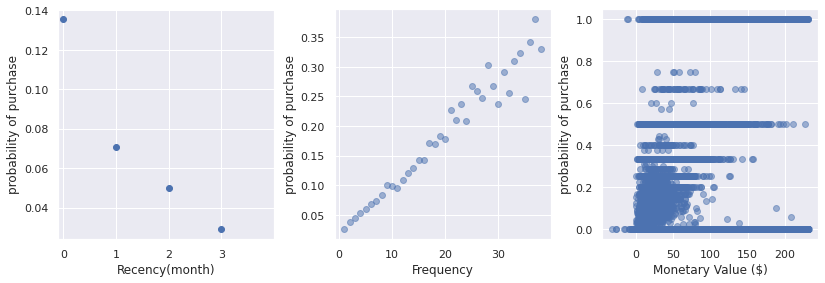

In [11]:
# Step 3 and 4: calculate and visualize the relationship between the probability of purchasing and RFM 
sns.set()
plt.figure(figsize=(12,4))

# plot purchase probability and Recency 
plt.axes([0,0,0.25,0.8])
df_Buy_R=df_sales2.groupby('Recency').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_R['Probability']=df_Buy_R['Buy']/df_Buy_R['Number']
plt.scatter(x=df_Buy_R.index,y=df_Buy_R.Probability)
plt.xlim(-0.1,4)
plt.xticks(np.arange(0,4,1))
plt.xlabel('Recency(month)')
plt.ylabel('probability of purchase')

# plot purchase probability and Frequency
plt.axes([0.32,0,0.25,0.8])
df_Buy_F=df_sales2.groupby('Frequency').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_F['Probability']=df_Buy_F['Buy']/df_Buy_F['Number']
plt.scatter(x=df_Buy_F.index,y=df_Buy_F.Probability,alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('probability of purchase')

# plot purchase probability and Monetary
plt.axes([0.63,0,0.25,0.8])
df_Buy_M=df_sales2.groupby('Monetary').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_M['Probability']=df_Buy_M['Buy']/df_Buy_M['Number']
plt.scatter(x=df_Buy_M.index,y=df_Buy_M.Probability,alpha=0.5)
plt.xlabel('Monetary Value ($)')
plt.ylabel("probability of purchase");

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The probability of repurchasing in Feb 2020 increased as the customers’ recency decreased. For example, customers who were active in Jan 2020 had about 4 times as high probability of repurchasing as those who made their last order in Oct 2019. There was somewhat of a linear relationship between the probability of purchase and frequency. Customers with higher number of transactions were more likely to repurchase. However, how much a customer spent over the past 4 months didn’t seem to have any obvious relationships with his or her purchase probability.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In summary, using the RFM-based K-Means clustering method, I grouped customers into 4 segments: (1) Loyal Customers; (2) Potential Loyalist; (3) New Customers; (4) At-Risk. Additionally, I found a negative association between recency and purchase probability, and a positive relationship between frequency and purchase probability. I hope my work could help our marketing team design effective campaigns.





__References__

Chen Daqing (2012). Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. Database Marketing & Customer Strategy Management 19, 197-208
